In [1]:
%load_ext autoreload
%autoreload 2
import sys
#sys.path.insert(1, '/home/ximo/Documents/GitHub/skforecast')
%config Completer.use_jedi = False

## Libraries

In [2]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## Data

In [23]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split data in train snd backtest
# ==============================================================================
n_backtest = 36*3  # Last 9 years are used for backtest
data_train = data[:-n_backtest]
data_backtest = data[-n_backtest:]

## Backtest

In [24]:
# Backtest forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 15 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data,
                                    initial_train_size = len(data_train),
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = True
                               )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 96
Number of observations used for backtesting: 108
    Number of folds: 11
    Number of steps per fold: 10
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 1999-07-01 00:00:00 -- 2000-04-01 00:00:00
Data partition in fold: 1
    Training:   1991-07-01 00:00:00 -- 2000-04-01 00:00:00
    Validation: 2000-05-01 00:00:00 -- 2001-02-01 00:00:00
Data partition in fold: 2
    Training:   1991-07-01 00:00:00 -- 2001-02-01 00:00:00
    Validation: 2001-03-01 00:00:00 -- 2001-12-01 00:00:00
Data partition in fold: 3
    Training:   1991-07-01 00:00:00 -- 2001-12-01 00:00:00
    Validation: 2002-01-01 00:00:00 -- 2002-10-01 00:00:00
Data partition in fold: 4
    Training:   1991-07-01 00:00:00 -- 2002-10-01 00:00:00
    Validation: 2002-11-01 00:00:00 -- 2003-08-01 00:00:00
Data p

In [25]:
print(f"Error backtest: {metric}")

print(predictions_backtest.head(4).to_markdown())

Error backtest: [0.00726621]
|                     |     pred |
|:--------------------|---------:|
| 1999-07-01 00:00:00 | 0.712336 |
| 1999-08-01 00:00:00 | 0.750542 |
| 1999-09-01 00:00:00 | 0.802371 |
| 1999-10-01 00:00:00 | 0.806941 |


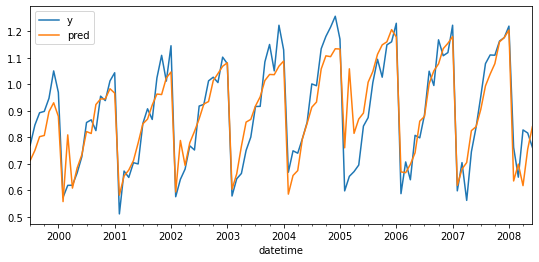

In [26]:
fig, ax = plt.subplots(figsize=(9, 4))
data_backtest.plot(ax=ax)
predictions_backtest.plot(ax=ax)
ax.legend();

## Backtest with prediction intervals

In [27]:
# Backtest forecaster
# ==============================================================================

forecaster = ForecasterAutoreg(
                regressor = Ridge(),
                lags      = 15 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data,
                                    initial_train_size = len(data_train),
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    interval   = [5, 95],
                                    n_boot     = 500,
                                    verbose    = True
                               )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 96
Number of observations used for backtesting: 108
    Number of folds: 11
    Number of steps per fold: 10
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1991-07-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 1999-07-01 00:00:00 -- 2000-04-01 00:00:00
Data partition in fold: 1
    Training:   1991-07-01 00:00:00 -- 2000-04-01 00:00:00
    Validation: 2000-05-01 00:00:00 -- 2001-02-01 00:00:00
Data partition in fold: 2
    Training:   1991-07-01 00:00:00 -- 2001-02-01 00:00:00
    Validation: 2001-03-01 00:00:00 -- 2001-12-01 00:00:00
Data partition in fold: 3
    Training:   1991-07-01 00:00:00 -- 2001-12-01 00:00:00
    Validation: 2002-01-01 00:00:00 -- 2002-10-01 00:00:00
Data partition in fold: 4
    Training:   1991-07-01 00:00:00 -- 2002-10-01 00:00:00
    Validation: 2002-11-01 00:00:00 -- 2003-08-01 00:00:00
Data p

In [28]:
print(f"Backtest error: {metric}")

Backtest error: [0.00779128]


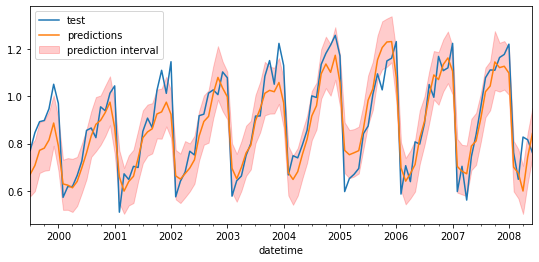

In [29]:
fig, ax=plt.subplots(figsize=(9, 4))
data_backtest.plot(ax=ax, label='test')
predictions_backtest.iloc[:, 0].plot(ax=ax, label='predictions')
ax.fill_between(
    predictions_backtest.index,
    predictions_backtest.iloc[:, 1],
    predictions_backtest.iloc[:, 2],
    color = 'red',
    alpha = 0.2,
    label = 'prediction interval'
)
ax.legend();

## Backtest with exogenous variables

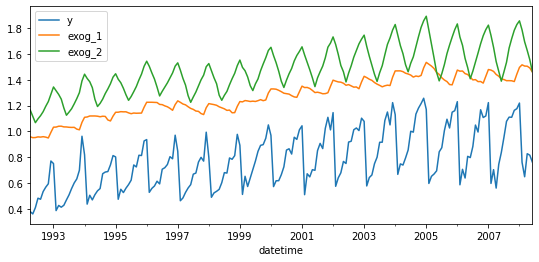

In [34]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv')
data = pd.read_csv(url, sep=',', header=0, names=['datetime', 'y', 'exog_1', 'exog_2'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data.sort_index()

# Split data in train snd backtest
# ==============================================================================
n_backtest = 36*3  # Last 9 years are used for backtest
data_train = data[:-n_backtest]
data_backtest = data[-n_backtest:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(9, 4))
data.plot(ax=ax);

In [35]:
# Backtest forecaster exogenous variables
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 15 
             )

metric, predictions_backtest = backtesting_forecaster(
                                    forecaster = forecaster,
                                    y          = data['y'],
                                    exog       = data[['exog_1', 'exog_2']],
                                    initial_train_size = len(data_train),
                                    steps      = 10,
                                    metric     = 'mean_squared_error',
                                    refit      = True,
                                    verbose    = True
                               )

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 11
    Number of steps per fold: 10
    Last fold only includes 8 observations.

Data partition in fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00
    Validation: 1999-07-01 00:00:00 -- 2000-04-01 00:00:00
Data partition in fold: 1
    Training:   1992-04-01 00:00:00 -- 2000-04-01 00:00:00
    Validation: 2000-05-01 00:00:00 -- 2001-02-01 00:00:00
Data partition in fold: 2
    Training:   1992-04-01 00:00:00 -- 2001-02-01 00:00:00
    Validation: 2001-03-01 00:00:00 -- 2001-12-01 00:00:00
Data partition in fold: 3
    Training:   1992-04-01 00:00:00 -- 2001-12-01 00:00:00
    Validation: 2002-01-01 00:00:00 -- 2002-10-01 00:00:00
Data partition in fold: 4
    Training:   1992-04-01 00:00:00 -- 2002-10-01 00:00:00
    Validation: 2002-11-01 00:00:00 -- 2003-08-01 00:00:00
Data p

In [36]:
print(f"Backtest error with exogenous variables: {metric}")

Backtest error with exogenous variables: [0.00683408]


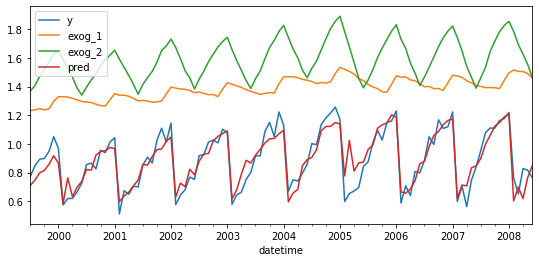

In [37]:
fig, ax = plt.subplots(figsize=(9, 4))
data_backtest.plot(ax=ax)
predictions_backtest.plot(ax=ax)
ax.legend();